In [1]:
import warnings
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math, copy, time
import pandas as pd
import matplotlib.pyplot as plt
import logging
from transformers import AutoTokenizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from utils import *
from main import *
from IPython.core.debugger import set_trace

logging.disable(logging.WARNING)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0') if USE_CUDA else torch.device("cpu")

# set random seed
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [2]:
entity_token = "[ETY]"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", additional_special_tokens=[entity_token])

G = read_MetaQA_KG()

qa_train_1h, qa_dev_1h, qa_test_1h = read_MetaQA_Instances("1-hop", entity_token, DEVICE)
qa_train_2h, qa_dev_2h, qa_test_2h = read_MetaQA_Instances("2-hop", entity_token, DEVICE)
qa_train_3h, qa_dev_3h, qa_test_3h = read_MetaQA_Instances("3-hop", entity_token, DEVICE)

qa_train = pd.concat([qa_train_1h, qa_train_2h, qa_train_3h])
qa_dev   = pd.concat([  qa_dev_1h,   qa_dev_2h,   qa_dev_3h])
qa_test  = pd.concat([ qa_test_1h,  qa_test_2h,  qa_test_3h])

In [3]:
possible_actions = ["[PAD]", "[SOS]"] + sorted(list(set([edge[2]["type"] for edge in G.edges(data=True)]))) + ["terminate"]
action_to_ix = dict(map(reversed, enumerate(possible_actions)))

In [6]:
emb_size = 256
hidden_size = 256
num_layers = 1

model = make_model(len(tokenizer), len(possible_actions), emb_size=emb_size, hidden_size=hidden_size, num_layers=num_layers, dropout=0.2).to(DEVICE)
model.load_state_dict(torch.load("checkpoints/e256_h256_l01_g090_k010_m2000000/save@2000000.pt")["model"])

<All keys matched successfully>

In [84]:
def simulate_episode(G, qa_instance, tokenizer, model, action_to_ix, max_len, epsilon, verbose=False):

    question, decorated_entity, answer_set = qa_instance
    tokenized_inputs = tokenizer(question, max_length=50, padding=True, truncation=True, return_tensors="pt")
    src, src_mask = tokenized_inputs["input_ids"].to(DEVICE), tokenized_inputs["attention_mask"].unsqueeze(-2).to(DEVICE)
    assert decorated_entity in G.nodes
    kgnode = decorated_entity

    if verbose:
        print(question)
        print(kgnode)

    kgnode_chain = []
    action_chain = []
    reward_chain = []
    
    attn_probs_chain = []
    
    encoder_hidden, encoder_final = model.encode(src, src_mask, [src_mask.sum().item()])

    # pre-compute projected encoder hidden states
    # (the "keys" for the attention mechanism)
    # this is only done for efficiency
    proj_key = model.decoder.attention.key_layer(encoder_hidden)

    # initialize decoder hidden state
    hidden_init = model.decoder.init_hidden(encoder_final)
    sos_embed = model.trg_embed(torch.tensor([action_to_ix["[SOS]"]], device=DEVICE)).unsqueeze(1)
    _, hidden, context, attn_probs = model.decoder.forward_step(sos_embed, encoder_hidden, src_mask, proj_key, hidden_init)

    for t in range(max_len):
        # compute the action value functions for available actions at the current node
        actions = unique([info["type"] for (_, _, info) in G.edges(kgnode, data=True)]) + ["terminate"]
        values = model.evaluator(context)[0, 0, [action_to_ix[action] for action in actions]]

        # select the action at the current time step with epsilon-greedy policy
        if random.random() < epsilon:
            action = random.choice(actions)
        else:
            action = actions[values.argmax()]

        # take the action
        if (action == "terminate") or (t == max_len-1):
            reward = torch.tensor(1.0 if ((action == "terminate") and (re.match(r".+: (.+)", kgnode).group(1) in answer_set)) else 0.0).to(DEVICE)
            kgnode_next = "termination"
            hidden_next = None
            context_next = None
        else:
            reward = torch.tensor(0.0).to(DEVICE)
            kgnode_next = random.choice(list(filter(lambda tp: tp[2]["type"] == action, G.edges(kgnode, data=True))))[1]
            action_embed = model.trg_embed(torch.tensor([action_to_ix[action]], device=DEVICE)).unsqueeze(1)
            _, hidden_next, context_next, attn_probs = model.decoder.forward_step(action_embed, encoder_hidden, src_mask, proj_key, hidden)

        kgnode_chain.append(kgnode)
        action_chain.append(action)
        reward_chain.append(reward)
        
        attn_probs_chain.append(attn_probs.reshape(-1).tolist())

        if verbose:
            print(actions)
            print(values.data.reshape(-1).to("cpu"))
            print(action, "  =====>  ", kgnode_next)

        if kgnode_next == "termination":
            break
        else:
            kgnode = kgnode_next
            hidden = hidden_next
            context = context_next

    return kgnode_chain, action_chain, reward_chain, attn_probs_chain

In [85]:
def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

In [86]:
def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

In [97]:
qa_instance = qa_train_3h[20]
kgnode_chain, action_chain, reward_chain, attn_probs_chain = simulate_episode(G, qa_instance, tokenizer, model, action_to_ix, 4, 0, verbose=True)
src_text = tokenizer.convert_ids_to_tokens(tokenizer(qa_instance.question).input_ids)
print("success" if reward_chain[-1] == 1.0 else "failure")

who starred films for the director of [ETY]
movie: Houdini
['fwd_directed_by', 'fwd_release_year', 'fwd_written_by', 'terminate']
tensor([ 0.5897, -0.0768,  0.2001,  0.0849])
fwd_directed_by   =====>   director: George Marshall
['rvs_directed_by', 'terminate']
tensor([ 0.5442, -0.0218])
rvs_directed_by   =====>   movie: A Millionaire for Christy
['fwd_directed_by', 'fwd_has_genre', 'fwd_release_year', 'fwd_starred_actors', 'terminate']
tensor([ 0.0636, -0.0589,  0.0508,  0.4717, -0.0446])
fwd_starred_actors   =====>   actor: Fred MacMurray
['rvs_starred_actors', 'terminate']
tensor([0.1161, 0.6495])
terminate   =====>   termination
success


<ipython-input-86-28e278b2a524>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(trg, minor=False, rotation='vertical')
<ipython-input-86-28e278b2a524>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(src, minor=False)


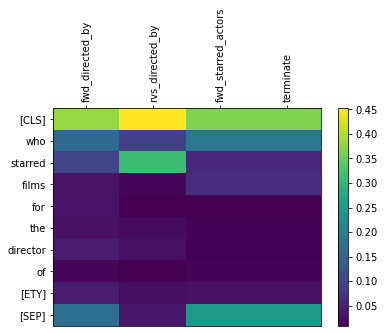

In [98]:
plot_heatmap(src_text, action_chain, np.array(attn_probs_chain).T)

In [89]:
np.array(attn_probs_chain).T.shape

(15, 4)